# Sklearn Pipeline

We use sklearn pipeline to build a model sequentially. The purpose of pipeline is to apply several steps sequentially in a combined manner rather doing one by one. In this Lab we will build a simple pipeline and will also use grid serach on the pipeline for hyperparmeter optimization. 

* [Sklearn pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

For this we use the digits dataset from sklearn load_digits. We will train a svm model. But before this we will apply PCA for feature reduction. We will do this using sklearn pipeline in a single step rather doing those separately. Later we apply grid search on the pipeline for hyperparmeter optimization. 

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

## Load dataset.
We are using the MNIST digit dataset. A modified version of digit dataset is already available in the sklearn dataset module.

In [2]:
digits = load_digits()

### Data Inspection

In [3]:
print('Sample and Features: ', digits.data.shape)
print('Target class:', digits.target_names)

Sample and Features:  (1797, 64)
Target class: [0 1 2 3 4 5 6 7 8 9]


### Visualize

Randomly visualize some sample from the datatset. 

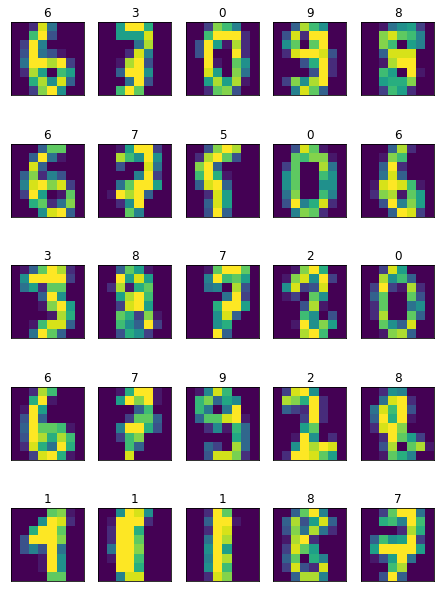

In [4]:
from matplotlib import pyplot

row = 5
col = 5
total_sample = len(digits.data)

pyplot.subplots_adjust(bottom=0, left=.01, right=.99, top=2, hspace=.35)


for i in range(row*col):
    pyplot.subplot(row, col, i+1)
    random_index = np.random.randint(0, total_sample)
    single_label = np.copy(digits.data[random_index, :])
    single_label = single_label.reshape((8,8))
    pyplot.title(digits.target[random_index], size=12)
    pyplot.xticks(())
    pyplot.yticks(())
    pyplot.imshow(single_label)
    
    

### Split the dataset
Split the dataset for testing and training purpose. We are spliting the dataset to training (80%) and  testing (20%).

In [5]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size = .2)

# Stage 1: Building a Vanilla Pipeline 
We will build a pipeline which first use PCA to reduce the dimentionality of the features data and then will use a classifier to train and predict the data.

## Defining the segments of the pipe

Here we define a pipeline as an ordered list of classes that will work on the data.

In the example below:

  1. Data --> PCA --> Data_Features

  2. Data_Features --> LinearSVC --> Classifications

Therefore, 
  1. Data --> Pipeline --> Classifications

In [6]:
# For stage 1 we set the pca_components with a fixed value 20
pca_components = 20

# This pipeline will run the PCA first then use the output of the PCA as the input of the SVC model
pipe = Pipeline([
    ('PCA', PCA(n_components= pca_components)), # it will reduce the feature vector to size of 20
    ('SVC', SVC(kernel='rbf'))                  # Then it will train an SVC with the reduced 20 size feature vector
])

## Train the pipeline

In [7]:
# Fit function will first run the pca and reduce the feature
# then train the SVM
pipe.fit(X_train, y_train)

Pipeline(steps=[('PCA', PCA(n_components=20)), ('SVC', SVC())])

## Predict with the pipeline

In [8]:

# Predict from test values
y_pred = pipe.predict(X_test)

# confusion_matrix 
pd.DataFrame(confusion_matrix(y_test, y_pred))


,0,1,2,3,4,5,6,7,8,9
0,40,0,0,0,0,0,0,0,0,0
1,0,37,0,0,0,0,0,0,0,0
2,0,0,31,0,0,0,0,0,0,0
3,0,0,0,30,0,0,0,0,0,0
4,0,0,0,0,34,0,0,0,0,0
5,0,0,0,0,0,34,1,0,0,1
6,0,0,0,0,0,0,44,0,0,0
7,0,0,0,0,0,0,0,35,0,0
8,0,2,0,0,0,0,0,0,30,0
9,0,0,0,0,0,0,0,0,0,41


# Pipeline score
Score function of Pipeline will provide the accuracy of the trained pipeline.

In [9]:
pipe.score(X_test, y_test)

0.9888888888888889

## Show classification report 
It shows the precision, recall, and f1 for each class. 

In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.95      1.00      0.97        37
           2       1.00      1.00      1.00        31
           3       1.00      1.00      1.00        30
           4       1.00      1.00      1.00        34
           5       1.00      0.94      0.97        36
           6       0.98      1.00      0.99        44
           7       1.00      1.00      1.00        35
           8       1.00      0.94      0.97        32
           9       0.98      1.00      0.99        41

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360



# Stage 2: GridSearch over a Pipeline

It's awesome to have a single pipeline and do preprocessing and train at once. But its not a good idea to use manual params for the each part of the pipeline. One more interesting part is that we could perform `GridSearch` and `RandomSearch` over a pipeline for hyper parameter tuning. 

To perform the hyperparameter tuning over a pipeline, we need to concatenate the model name as a prefix of param name with underscore `_`. For example, if we want to do `GridSearch` over the `kernel` params of  `SVC`,  then the name of this parameter in the configuration will be `SVC_kernel`.


In [11]:
# import grid search
from sklearn.model_selection import GridSearchCV


# select params list to do grid search here all the pramas name is concatenated with __ preceding the model name

# param configuration
param_grid = {'PCA__n_components': [20, 30],
              'SVC__C': [1e3, 5e3],        
              'SVC__kernel': ['rbf']}


# Now build the pipeline again
clf_pipe = Pipeline([
    ('PCA', PCA()), 
    ('SVC', SVC())                 
])

# Now apply the params to the classifier pipe using grid search
grid_model = GridSearchCV(clf_pipe, param_grid = param_grid, n_jobs=5)

## Fit the Grid

In [12]:
# It will try out all the combination of parameters and choose the best params set 
grid_model.fit(X_train, y_train)

# Check the best choosen params
print(grid_model.best_estimator_)

Pipeline(steps=[('PCA', PCA(n_components=30)), ('SVC', SVC(C=1000.0))])


## Classification report

In [13]:
predicted_y = grid_model.predict(X_test)
print(classification_report(y_test, predicted_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.95      1.00      0.97        37
           2       1.00      1.00      1.00        31
           3       1.00      1.00      1.00        30
           4       1.00      1.00      1.00        34
           5       1.00      0.94      0.97        36
           6       0.98      1.00      0.99        44
           7       1.00      1.00      1.00        35
           8       1.00      0.94      0.97        32
           9       0.98      1.00      0.99        41

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360

